In [1]:
import numpy as np
import lsst.daf.persistence as dafPersist
import lsst.afw.display.ds9 as ds9
import lsst.afw.display.utils as displayUtils
import lsst.afw.display.rgb as afwRgb
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.detection as afwDetection
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (13, 8)

In [2]:
class Families(list):
    def __init__(self, cat, butler=None, nChildMin=None):
        '''
        Returns [ (parent0, [child0, child1]), (parent1, [child0, ...]), ...]
        where parents are sorted by ID.  Only objects that are deblended are included (unless nChildMin == 0)

        if nChildMin is not None, include only deblends with at least than many children.  As a
        special case, nChildMin == 0 includes all objects, even those that aren't blended
        '''
        self.cat = cat

        # parent -> [children] map.
        children = {}
        for src in cat:
            pid = src.getParent()
            if not pid:
                continue

            if pid in children:
                children[pid].append(src)
            else:
                children[pid] = [src]

        parentIds = children.keys()
        #
        # Impose nChildMin
        #
        if nChildMin == 0:                  # include all objects:
            for src in cat:
                if src.getParent():         # already accounted for
                    continue

                sid = src.getId()
                if sid not in parentIds:
                    children[sid] = []
        elif nChildMin is not None:
            for pid in parentIds:
                if len(children[pid]) < nChildMin:
                    del children[pid]

        parentIds = sorted(children.keys())

        for pid in parentIds:
            self.append((cat.find(pid), children[pid]))

    def find(self, objId, matchRadius=10):
        """Return the object's family (you may specify either the ID for the parent or a child)"""
        x, y = None, None
        try:
            x, y = objId
        except TypeError:
            pass

        if x is not None:
            oneObjCatalog = afwTable.SourceCatalog(self.cat.getSchema())
            centroidName = self.cat.table.getCentroidDefinition()
            oneObjCatalog.table.defineCentroid(centroidName)

            s = oneObjCatalog.addNew()
            s.set("slot_Centroid_x", x)
            s.set("slot_Centroid_y", y)

            matched = afwTable.matchXy(self.cat, oneObjCatalog, matchRadius)

            if len(matched) == 0:
                print >> sys.stderr, "Unable to find object at (%.2f, %.2f)" % (x, y)
                return None

            if False:
                objId = splitId(matched[0][0].getId())["objId"]
            else:
                objId = matched[0][0].getId()

        if False:
            family = [f for f in self if self.mapperInfo.getId(f[0]) == objId]
        else:
            family = [f for f in self if f[0].getId() == objId]
        if family:
            return family[0]

        for family in self:
            for child in family[1]:
                if False:
                    if self.mapperInfo.getId(child) == objId:
                        return family
                else:
                    if child.getId() == objId:

                        return family

        return None

In [3]:
def splitId(i):
    i = np.array(i)
    oid = i & (2**32 - 1)
    i >>= 32
    ccd = i % 200
    i //= 200
    visit = i
    
    return dict(visit=visit, ccd=ccd, oid=oid)

def splitId(i, isCoadd=True):
    """Split an ObjectId into visit, ccd, and objId.
    See obs/subaru/python/lsst/obs/suprimecam/suprimecamMapper.py"""
    
    i = np.array(i, dtype='int64')
    oid = i & (2**32 - 1)
    i >>= 32

    if isCoadd:
        pass
    else:
        ccd = i % 200
        i //= 200
        visit = i
    
        return dict(visit=visit, ccd=ccd, oid=oid)

    if isCoadd:
        nfilter = len(butler.mapper.filters)
        nPatches = 1000000L

        ifilter = oid % nfilter
        oid //= nfilter

        patch = oid % nPatches
        oid //= nPatches

        stack = int(oid)

        filter = [k for k,v  in butler.mapper.filterIdMap.items() if v == ifilter][0]

        if asDict:
            return dict(stack=stack, patch=patch, filter=filter, objId=objId)
        else:
            return stack, patch, filter, objId

def showDeblendRGB(parent, bands=['g', 'r', 'i'],
                   min=0.01, max=0.5, Q=8, rgbFileFmt=None):
    x, y = parent.getX(), parent.getY()

    fams = {}
    imBbox = afwGeom.BoxI()
    for bandName in "GRI".upper():
        filterName = "HSC-%s" % bandName

        x0, y0 = coaddDict[filterName].getXY0()
        x0, y0 = 0, 0
        fams[filterName] = familiesDict[filterName].find((x + x0, y + y0), matchRadius=20)
        if not fams[filterName]:
            return
        parent, kids = fams[filterName]

        bbox = parent.getFootprint().getBBox()
        for kid in kids:
            kim = footprintToImage(kid.getFootprint(), coaddDict[filterName].getMaskedImage())
            bbox.include(kim.getBBox(afwImage.PARENT))

        imBbox.include(bbox)

    images = {} 
    for bandName in bands:
        filterName = "HSC-%s" % bandName.upper()

        images[bandName] = makeDeblendFamilyMosaic(coaddDict[filterName].getMaskedImage(),
                                                   *fams[filterName],
                                                    background=-0.1, imBbox=imBbox).makeMosaic()
        if False and bandName == "R":
            disp.mtv(images[bandName])

    for bands in [bands]:
        B, G, R = bands
        rgb = afwRgb.makeRGB(images[R], images[G], images[B], min, max - min, Q)

        afwRgb.displayRGB(rgb)

        print rgbFileFmt
        if rgbFileFmt:
            afwRgb.writeRGB(rgbFileFmt % "".join(bands), rgb)

In [4]:
foo = ds9.callbacks['r']
%pdb 0
foo('r', 3758, 823)
#os.getcwd()

Automatic pdb calling has been turned OFF


False

In [5]:
def footprintToImage(fp, mi=None, mask=False):
    if fp.isHeavy():
        fp = afwDetection.cast_HeavyFootprintF(fp)
    elif mi is None:
        print >> sys.stderr, "Unable to make a HeavyFootprint as image is None"
    else:
        fp = afwDetection.makeHeavyFootprint(fp, mi)
    bb = fp.getBBox()
    if mask:
        im = afwImage.MaskedImageF(bb.getWidth(), bb.getHeight())
    else:
        im = afwImage.ImageF(bb.getWidth(), bb.getHeight())
    im.setXY0(bb.getMinX(), bb.getMinY())

    try:
        fp.insert(im)
    except AttributeError:              # we failed to make it heavy
        assert not mi
        pass
    
    if mask:
        im = im.getMask()
    return im

def makeDisplayFamily(calexp, families, matchRadius=20, background=-0.1, display=None, rgb=False):
    """Factory function for callback function implementing showBlend"""
    def display_family(k, x, y):
        if calexp is not None:
            xy0 = calexp.getXY0()
            x += xy0[0]
            y += xy0[1]
        fam = families.find((x, y), matchRadius=matchRadius)
        if fam:
            if rgb:
                showDeblendRGB(fam[0], rgbFileFmt="AI-%.0f,%.0f-%%s.png" % (x, y))
                # print splitId(fam[0].getId())
            else:
                plotDeblendFamily(calexp, *fam, mapperInfo=None, background=background, 
                                  display=display)

    return display_family

def makeDeblendFamilyMosaic(mi, parent, kids, mapperInfo=None,
                            background=-10, maskbit=False, imBbox=None):
    """Create a mosaic of an object's children
    """

    aa = {}
    if maskbit:
        aa.update(mask=True)
    parent_im = footprintToImage(parent.getFootprint(), mi, **aa)
    bbox = afwGeom.BoxD(parent.getFootprint().getBBox())
    pext = (bbox.getMinX(), bbox.getMaxX(), bbox.getMinY(), bbox.getMaxY())

    pks = parent.getFootprint().getPeaks()
    pix = [pk.getIx() for pk in pks]
    piy = [pk.getIy() for pk in pks]
    pfx = [pk.getFx() for pk in pks]
    pfy = [pk.getFy() for pk in pks]

    N = 1 + len(kids)
    S = np.ceil(np.sqrt(N))
    C = S
    R = np.ceil(float(N)/C)

    Rx,Ry = [],[]
    tts = []
    stys = []
    xys = []
    #
    # Find how large an image we need to display the parent and all the children
    #
    kidImages, kim = {}, None
    for kid in kids:
        kim = footprintToImage(kid.getFootprint(), mi, **aa)
        kidImages[kid] = kim

    if not kim:
        kim = parent_im.clone()

    if not imBbox:
        imBbox = parent_im.getBBox(afwImage.PARENT)
        for kid in kids:
            imBbox.include(kidImages[kid].getBBox(afwImage.PARENT))

    mos = displayUtils.Mosaic(background=background)
        
    bbox = afwGeom.Box2I(afwGeom.Point2I(kim.getX0() - imBbox.getMinX(),
                                         kim.getY0() - imBbox.getMinY()), kim.getDimensions())

    kidImages[parent] = parent_im       # not strictly a kid

    for kid in [parent] + kids:
        kim = kidImages[kid]
        #
        # Put the child into the correct place in the parent image.  We have to do this for
        # the parent too if some of the children extended outside it's BBox
        #
        bbox = afwGeom.Box2I(afwGeom.Point2I(kim.getX0() - imBbox.getMinX(),
                                             kim.getY0() - imBbox.getMinY()), kim.getDimensions())

        _kim = parent_im.Factory(imBbox)
        _kim[bbox] <<= kim
        mos.append(_kim, '%d%s' % (mapperInfo.getId(kid) if mapperInfo else (kid.getId() & 0xfff),
                                   "P" if kid == parent else "C"))
        del _kim

    return mos

def plotDeblendFamily(mi, parent, kids, mapperInfo=None, dkids=[],
                      background=-10, symbolSize=2,
                      plotb=False,
                      arcsinh=True, maskbit=False, display=afwDisplay.getDisplay(0)):
    """Display a deblend using afwDisplay

Each child is marked with a + at its centre (green if deblended-as-psf else red)
all the other peaks in its footprint are marked with x (cyan if deblended-as-psf else magenta)
    """

    if mi:
        try:
            mi = mi.getMaskedImage()        # maybe it's an Exposure?
        except AttributeError:
            pass
    
    mos = makeDeblendFamilyMosaic(mi, parent, kids, mapperInfo, background, maskbit)

    if mapperInfo:
        title = re.sub(r"[{}']", "", str(mapperInfo.getId(parent, None))) # ds9 doesn't handle those chars well
    else:
        title = "0x%x == %d" % (parent.getId(), (parent.getId() & 0xffff))

    mosaicImage = mos.makeMosaic(display=display, title=title)

    display.dot("%s  (%.1f, %1.f)" % (title, parent.getX(), parent.getY()),
            0.5*mosaicImage.getWidth(), 1.03*mosaicImage.getHeight(),
            ctype=afwDisplay.BLACK, fontFamily="times", size=3)

    px0, py0 = footprintToImage(parent.getFootprint(), mi).getXY0()

    with display.Buffering():
        for i, src in enumerate([parent] + kids):    
            x0, y0 = mos.getBBox(i).getMin()
            x0 -= px0; y0 -= py0

            if src.get("deblend_deblendedAsPsf"):
                centroid_ctype = afwDisplay.GREEN
                peak_ctype = afwDisplay.CYAN
            else:
                centroid_ctype = afwDisplay.RED
                peak_ctype = afwDisplay.MAGENTA
            
            display.dot("+", src.getX() + x0, src.getY() + y0,
                    size=symbolSize, ctype=centroid_ctype)
            for p in src.getFootprint().getPeaks():
                display.dot("x", p.getFx() + x0, p.getFy() + y0,
                        size=0.5*symbolSize if i == 0 else symbolSize,
                        ctype=afwDisplay.YELLOW if i == 0 else peak_ctype)
                
def showBlend(calexp, families, key='d', background=-0.1, display0=afwDisplay.getDisplay(0),
              display=None, mtv=False):
    """Show blends interactively on an afwDisplay

    \param calexp   Exposure containing objects of interest
    \param families A Families object
    \param key      Key to display the family under the cursor in Display display
    \param display0 The afwDisplay.Display to display the families
    \param display  The afwDisplay.Display displaying calexp (see mtv)
    \param mtv      If true, display calexp on display

E.g.
import lsst.daf.persistence as dafPersist
import lsst.analysis.deblender as deblender

butler = dafPersist.Butler("/home/astro/hsc/hsc/HSC/rerun/rhl/tmp")
did = dict(visit=905518, ccd=31)
calexp = butler.get("calexp", **did)
ss = butler.get("src", **did)
families = deblender.Families(ss, butler, nChildMin=0)
deblender.showBlend(calexp, families, display=afwDisplay.Display(1))

Then hit 'key' (default: d) on objects of interest; 'r' for an rgb image
"""
    if display is not None:
        if mtv:
            display.mtv(calexp)

    old = {}
    try:
        for k in set(list("ha") + [key]):
            old[k] = display.setCallback(k)

        display.setCallback(key, makeDisplayFamily(calexp, families, display=display0))
        def new_h(*args):
            old['h'](*args)
            print "   1,2,4,8: Zoom to specified scale"
            print "   a:       show All the pixels"
            print "   %s:      show family under the cursor and return to python prompt" % key
            print "   l:       cycle through stretch types"
        display.setCallback('h', new_h)
        display.setCallback('a', lambda k, x, y: display.zoom("to fit"))
        for z in [1, 2, 4, 8]:
            def _zoom(k, x, y, z=z):
                display0.zoom(z)
            display.setCallback('%d' % z, _zoom)
        
        def callbackLog(k, x, y, i=[0]):
            """Cycle through stretches"""
            i[0] = (i[0] + 1)%3
            if i[0] == 0:
                display.scale("log", "minmax")
            elif i[0] == 1:
                display.scale("linear", "minmax")
            elif i[0] == 2:
                display.scale("linear", "zscale")

        display.setCallback('r', makeDisplayFamily(calexp, families, rgb=True))

        display.interact()
    except Exception, e:
        print "RHL", e
    finally:
        print "Cleaning up"
        for k, func in old.items():
            display.setCallback(k, func)

In [6]:
import os

if "SUPRIME_DATA_DIR" not in os.environ:
    os.environ["SUPRIME_DATA_DIR"] = "/tigress/HSC/HSC" if True else \
                                     "/lustre/Subaru/SSP"
        
dataPath = os.path.join(os.environ["SUPRIME_DATA_DIR"], "rerun", "production-20151224")

butler = dafPersist.Butler(dataPath)
skymap = butler.get("deepCoadd_skyMap")

In [12]:
def decimalRaDec(raStr, decStr):
    """Convert ra, dec as strings to decimals.
    A leading sign for the dec field is optional
    
    E.g. decimalRaDec("09:59:21.76", "+02:06:38.4")
    """
    ra, dec = raStr.split(':'), decStr.split(':')
    if dec[0][0] in "-+":
        decSign = +1 if dec[0][0] == '+' else -1
        dec[0] = dec[0][1:]
    else:
        decSign = +1
        
    d, m, s = [float(_) for _ in dec]
    dec = decSign*(d + (m + s/60.0)/60.0)
    
    h, m, s = [float(_) for _ in ra]
    ra = 15*(h + (m + s/60.0)/60.0)
    
    return ra, dec

In [7]:
if True:
    if True:
        ra, dec = (215.9747, -0.4344)
    else:
        ra, dec = [#("09:59:21.76", "+02:06:38.4"),
                   ("22:20:12.83", "+01:20:23.7"),
                   ("02:15:19.24", "-03:48:11.1"),
                   ("02:28:41.53", "-05:00:05.4"),
                   ("22:16:08.70", "+00:55:39.1"),
                   ("22:24:25.92", "+01:21:21.7"),
                   ][0]
        ra, dec = decimalRaDec(ra, dec)
    
    raDec = afwCoord.Coord(ra*afwGeom.degrees, dec*afwGeom.degrees)
    tractInfo, patchInfo = skymap.findClosestTractPatchList([raDec])[0]
    
    dataId = dict(tract = tractInfo.getId(),
                  patch = "%d,%d" % patchInfo[0].getIndex(),
                  filter='HSC-Z')
else:
    dataId = dict(tract=8766, patch='2,1', filter='HSC-I', sfilter='i')

print dataId["tract"], dataId["patch"]

coadd = butler.get("deepCoadd_calexp", dataId, immediate=True)

9372 6,6


In [8]:
ss = butler.get('deepCoadd_forced_src' if False else 'deepCoadd_meas', dataId)
families = Families(ss, butler, nChildMin=0)

In [11]:
frame=1            # We'll use frame+1 for the children
if False:
    if True:
        ds9.mtv(coadd, title="%(tract)s %(patch)s" % dataId, frame=frame)
    else:
        ds9.erase(frame=frame)

    with ds9.Buffering():
        for s in ss:
            ds9.dot('+' if s['deblend.nchild'] > 0 else 'x',
                    s['cmodel.center.x'] - coadd.getX0(), s['cmodel.center.y'] - coadd.getY0(), size=3, 
                    ctype=ds9.RED, frame=frame)

No callback is registered for Shift_L
No callback is registered for Shift_L


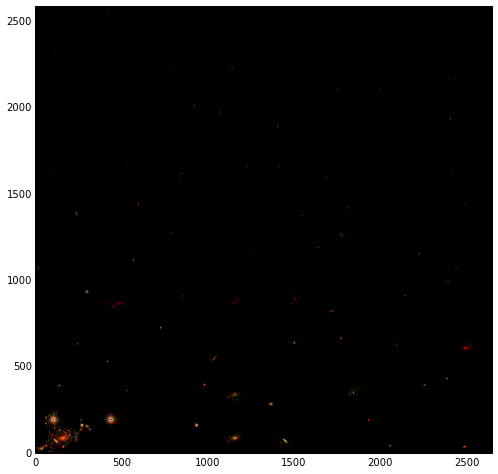

AI-24892,24629-%s.png
Cleaning up


In [15]:
#
# This puts us into a loop waiting on ds9.  Sigh.
# Use d on an object in frame frame to show the children in frame frame+1; q to quit the ds9 interactive loop
#
if True:
    showBlend(coadd, families, frame0=frame+1, frame=frame)

In [14]:
try:
    coaddDict
except NameError:
    coaddDict = {}
try:
    sourcesDict
except NameError:
    sourcesDict = {}
try:
    familiesDict
except NameError:
    familiesDict = {}
    
for bandName in "GRI":
    filterName = "HSC-%s" % bandName.upper()
    
    coaddDict[filterName] = butler.get("deepCoadd_calexp", dataId, filter=filterName)
    sourcesDict[filterName] = butler.get('deepCoadd_forced_src' if False else 'deepCoadd_meas',
                                         dataId, filter=filterName)
    sourcesDict[filterName].table.defineCentroid("centroid.sdss")
    familiesDict[filterName] = Families(sourcesDict[filterName], 
                                        butler, nChildMin=0)

/tigress/HSC/products-HSC-20150702/Linux64/afw/HSC-4.0.0/python/lsst/afw/display/rgb.py:145: RuntimeWarning: overflow encountered in divide
  np.where(b0 >= pixmax, c*pixmax/b0, c)),
/tigress/HSC/products-HSC-20150702/Linux64/afw/HSC-4.0.0/python/lsst/afw/display/rgb.py:147: RuntimeWarning: overflow encountered in divide
  np.where(g0 >= pixmax, c*pixmax/g0, c),
/tigress/HSC/products-HSC-20150702/Linux64/afw/HSC-4.0.0/python/lsst/afw/display/rgb.py:148: RuntimeWarning: overflow encountered in divide
  np.where(b0 >= pixmax, c*pixmax/b0, c))).astype(np.uint8)
/tigress/HSC/products-HSC-20150702/Linux64/afw/HSC-4.0.0/python/lsst/afw/display/rgb.py:144: RuntimeWarning: overflow encountered in divide
  np.where(r0 >= pixmax, c*pixmax/r0, c),


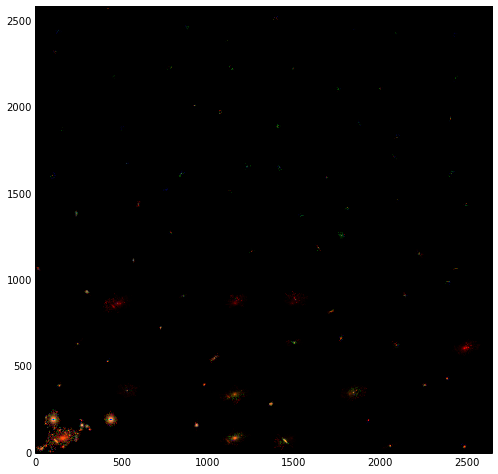

gri


In [16]:
x, y = ((24890, 24629) if True else 
        (10077, 5846) if True else 
        (8611, 6379) if False else 
        (8271, 7406) if False else 
        (8719, 7137) if False else 
        (8442, 7208) if False else
        (8166, 7080)
        )

x, y = coaddDict['HSC-G'].getWcs().skyToPixel(ra*afwGeom.degrees, dec*afwGeom.degrees)

fams = {}
imBbox = afwGeom.BoxI()
for bandName in "GRI".upper():
    filterName = "HSC-%s" % bandName

    x0, y0 = coaddDict[filterName].getXY0()
    fams[filterName] = familiesDict[filterName].find((x, y), matchRadius=20)
    parent, kids = fams[filterName]
    
    bbox = parent.getFootprint().getBBox()
    for kid in kids:
        kim = footprintToImage(kid.getFootprint(), coaddDict[filterName].getMaskedImage())
        bbox.include(kim.getBBox(afwImage.PARENT))

    imBbox.include(bbox)
    
images = {} 
for bandName in "GRI".upper():
    filterName = "HSC-%s" % bandName

    images[bandName] = makeDeblendFamilyMosaic(coaddDict[filterName].getMaskedImage(),
                                               *fams[filterName],
                                                background=-0.1, imBbox=imBbox).makeMosaic()
    if False and bandName == "R":
        ds9.mtv(images[bandName], frame=2)
    
rgbFileFmt = "foo-%s.png" if False else \
             "AI-%d-%s-%.0f,%.0f-%%s.png" % (dataId["tract"], dataId["patch"], x, y) if True else None
min = -0.0
max = 0.3
Q = 8

for bands in ["gri"]:
    B, G, R = bands.upper()
    rgb = afwRgb.makeRGB(images[R], images[G], images[B], min, max - min, Q)
    
    afwRgb.displayRGB(rgb)
    print bands
    
    if rgbFileFmt:
        afwRgb.writeRGB(rgbFileFmt % bands, rgb)